<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data-from-web-page" data-toc-modified-id="Get-data-from-web-page-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data from web page</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#说明:-百度百科上没有北京地铁机场线、燕房线的站点间隔信息，故在设计中没有考虑这两条线路；另外，亦庄线的网页格式比较特殊，爬取该网页的程序不具有一般性，故单独考虑亦庄线的信息提取。" data-toc-modified-id="说明:-百度百科上没有北京地铁机场线、燕房线的站点间隔信息，故在设计中没有考虑这两条线路；另外，亦庄线的网页格式比较特殊，爬取该网页的程序不具有一般性，故单独考虑亦庄线的信息提取。-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>说明: 百度百科上没有北京地铁机场线、燕房线的站点间隔信息，故在设计中没有考虑这两条线路；另外，亦庄线的网页格式比较特殊，爬取该网页的程序不具有一般性，故单独考虑亦庄线的信息提取。</a></span></li></ul></li></ul></li><li><span><a href="#Build-the-search-agent" data-toc-modified-id="Build-the-search-agent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the search agent</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#最小换乘优先" data-toc-modified-id="最小换乘优先-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>最小换乘优先</a></span></li><li><span><a href="#路程最短优先" data-toc-modified-id="路程最短优先-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>路程最短优先</a></span></li><li><span><a href="#continuous-transfer" data-toc-modified-id="continuous-transfer-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>continuous transfer</a></span></li></ul></li></ul></li></ul></div>

Please using the search policy to implement an agent. This agent receives two input, one is @param start station and the other is @param destination. Your agent should give the optimal route based on Beijing Subway system.

## Get data from web page

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import collections

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.84 Safari/537.36'
}

def craw(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

In [3]:
soup = craw('https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81/408485')
lines = soup.findAll('table')[4].findAll('a')[:-1]

In [4]:
lines[-3:]

[<a href="/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E4%BA%A6%E5%BA%84%E7%BA%BF" target="_blank">北京地铁亦庄线</a>,
 <a href="/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E7%87%95%E6%88%BF%E7%BA%BF" target="_blank">北京地铁燕房线</a>,
 <a href="/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E6%9C%BA%E5%9C%BA%E7%BA%BF" target="_blank">北京地铁机场线</a>]

In [5]:
stations_connection = collections.defaultdict(list)
dist = collections.defaultdict(int)
node_in_line = collections.defaultdict(set)

pattern = re.compile('([\w|\d]+)相邻站间距信息统计表')

for line in lines[:-3]:
    link = 'https://baike.baidu.com' + line.get('href')
    soup = craw(link)

    for caption in soup.find_all('caption'):
        line_name = re.findall(pattern, caption.get_text())
        if line_name:
            print('\n----The information of {} is following...'.format(line_name[0]))
            table = caption.find_parent('table')
            for neigbor in table.find_all('tr')[1:]:
                start, end = re.findall(re.compile('([\w|\d]+)——([\w|\d]+)'), neigbor.th.text)[0]
                distance = re.findall(re.compile('([\d]+)米*'), neigbor.td.text)[0]

                stations_connection[start].append(end)
                stations_connection[end].append(start)

                dist[(start,end)] = dist[(end,start)] = int(distance)
    
                node_in_line[start].add(line_name[0])
                node_in_line[end].add(line_name[0])

                #print('{}--{}: {}m'.format(start, end, distance))

            break


----The information of 2号线 is following...

----The information of 4号线 is following...

----The information of 5号线 is following...

----The information of 6号线 is following...

----The information of 7号线 is following...

----The information of 北京地铁8号线 is following...

----The information of 10号线 is following...

----The information of 13号线 is following...

----The information of 15号线 is following...

----The information of 昌平线 is following...

----The information of 房山线 is following...


#### 说明: 百度百科上没有北京地铁机场线、燕房线的站点间隔信息，故在设计中没有考虑这两条线路；另外，亦庄线的网页格式比较特殊，爬取该网页的程序不具有一般性，故单独考虑亦庄线的信息提取。

In [6]:
node_in_line['东直门'].add('亦庄线')
node_in_line['三元桥'].add('亦庄线')
node_in_line['T3航站楼'].add('亦庄线')
node_in_line['T2航站楼'].add('亦庄线')

stations_connection['东直门'].append('三元桥')
stations_connection['三元桥'].append('东直门')
dist[('东直门','三元桥')] = dist[('三元桥','东直门')] = 3022
stations_connection['T3航站楼'].append('三元桥')
dist[('T3航站楼','三元桥')] = 18322
stations_connection['T2航站楼'].append('东直门')
dist[('T2航站楼','T3航站楼')] = 7243
stations_connection['T2航站楼'].append('三元桥')
dist[('T2航站楼','三元桥')] = 20738

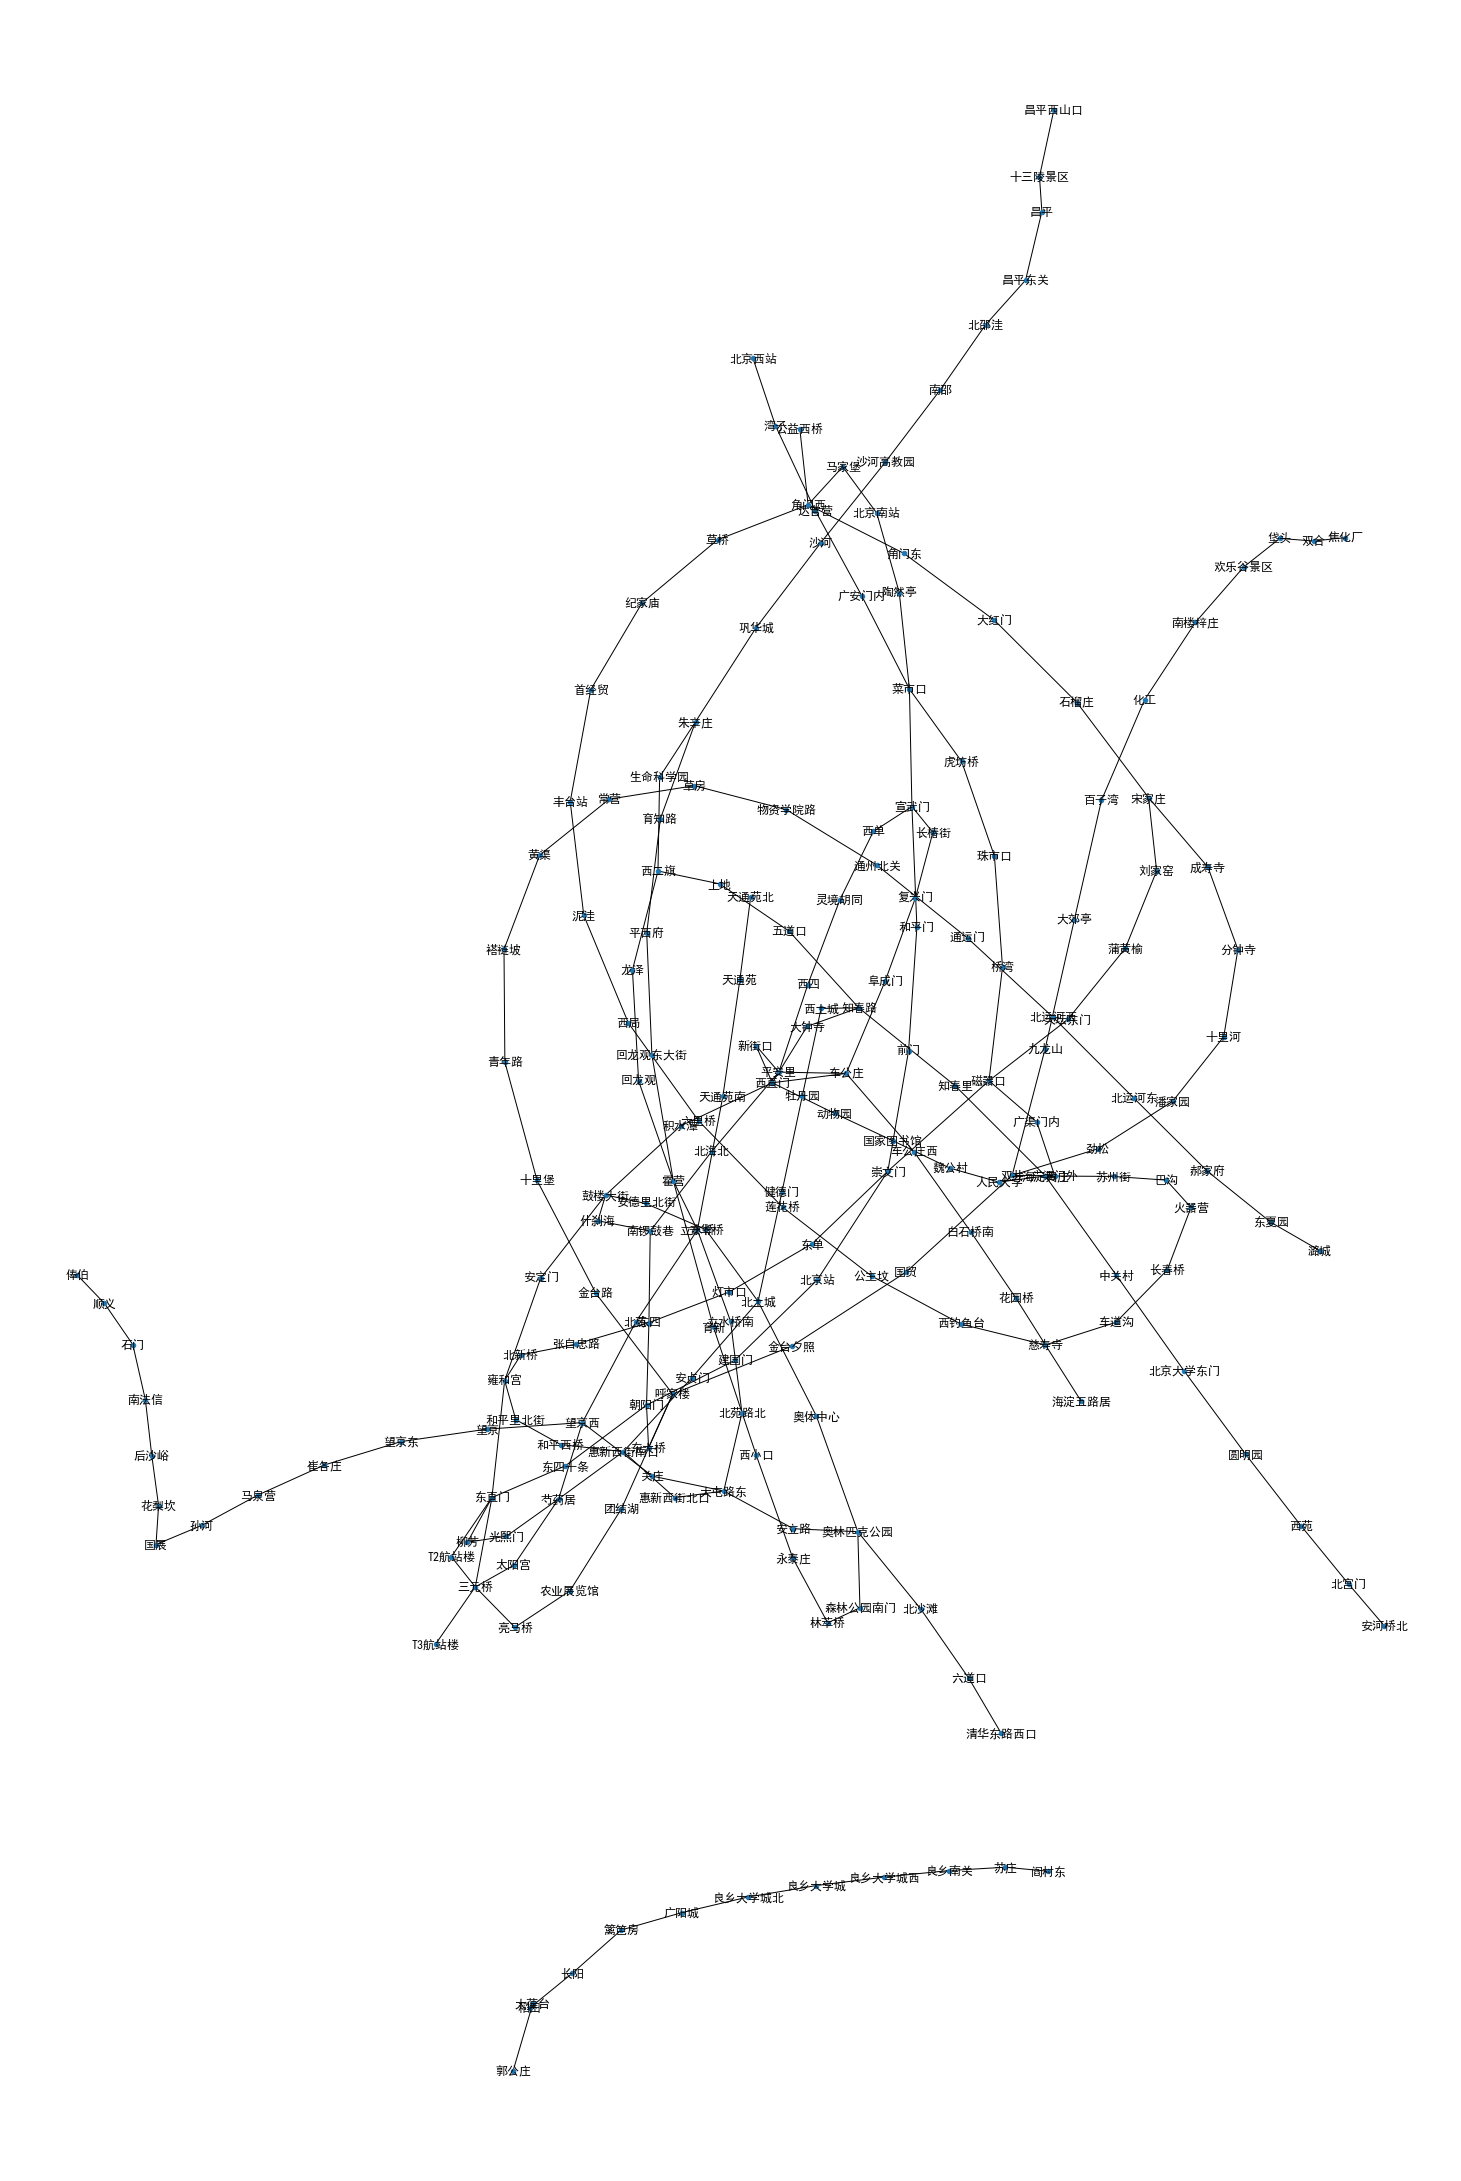

In [7]:
import networkx as nx

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

subway_graph = nx.Graph(stations_connection)

# pos = nx.spring_layout(subway_graph,k=0.2,iterations=10)
# nx.draw(subway_graph, pos, with_labels=True, node_size=200)

# 这句话确定图的大小
plt.figure(1,figsize=(20,30)) 
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
nx.draw(subway_graph, with_labels=True, node_size=20)
plt.show()

## Build the search agent

In [161]:
# goal function with continuous transfer
def is_goal(desitination, by_way=[]):
    def _wrap(current_path):
        for s in by_way:
            if s not in current_path:
                return False
        return current_path[-1] == desitination
    return _wrap

In [159]:
def sort_path(cmp_func, beam=-1):
    def _sorted(pathes):
        if beam == -1:
            return sorted(pathes, key=cmp_func)
        else:
            return sorted(pathes, key=cmp_func)[:beam]
    return _sorted

# 最小换乘
def get_total_swaps(path):
    
    if len(path) < 2:
        return 0
    
    res = 0
    pre_line = node_in_line[path[0]] &  node_in_line[path[1]]
    pre = path[1]
    
    for station in path[2:]:
        
        cur_line = node_in_line[station] &  node_in_line[pre]
        if cur_line != pre_line:
            res += 1
            
        pre_line = cur_line
        pre = station

    return res


# 路程最短优先
def get_path_distance(path):
    
    distance = 0
    
    for i, c in enumerate(path[:-1]):
        distance += dist[(c, path[i+1])]
    
    return distance


In [128]:
get_total_swaps(['大钟寺', '西直门', '车公庄', '阜成门', '复兴门', '长椿街', '宣武门', '和平门'])

1

In [157]:
get_path_distance(['大钟寺', '西直门', '车公庄', '阜成门', '复兴门', '长椿街', '宣武门', '菜市口', '陶然亭', '北京南站'])

12698

In [158]:
get_path_distance(['大钟寺', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站'])

12754

In [126]:
def search(graph, start, is_goal, search_stratery):

    pathes = [[start]]
    seen = set()
    
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]

#         if frontier in seen:    continue
         
        for station in graph[frontier]:
            if station in path: continue

            new_path = path + [station]
            pathes.append(new_path)
            
            if is_goal(new_path):   return new_path

#         seen.add(frontier)
        pathes = search_stratery(pathes)
    

#### 最小换乘优先

In [163]:
search(stations_connection, start='大钟寺', is_goal=is_goal('北京南站'), search_stratery=sort_path(get_total_swaps))

['大钟寺', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站']

#### 路程最短优先

In [165]:
search(stations_connection, start='大钟寺', is_goal=is_goal('北京南站'), search_stratery=sort_path(get_path_distance))

['大钟寺', '西直门', '车公庄', '阜成门', '复兴门', '长椿街', '宣武门', '菜市口', '陶然亭', '北京南站']

#### continuous transfer

In [162]:
search(stations_connection, start='大钟寺', is_goal=is_goal(desitination='北京南站', by_way = ['天安门西']), search_stratery=sort_path(get_path_distance))

['大钟寺',
 '西直门',
 '新街口',
 '平安里',
 '北海北',
 '南锣鼓巷',
 '东四',
 '灯市口',
 '东单',
 '王府井',
 '天安门东',
 '天安门西',
 '西单',
 '宣武门',
 '菜市口',
 '陶然亭',
 '北京南站']